In [2]:
import numpy as np
import random
import os
import time
import PIL.Image as Image 
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
import torchvision

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda")
print(device)

mps


In [4]:
# import all images from ../data-tumour/training 
yes_tumour_files = []
no_tumour_files = []

for filename in os.listdir('data-tumor/training/meningioma'):
    if filename.endswith(".jpg"):
        yes_tumour_files.append(filename)
for filename in os.listdir('data-tumor/training/notumor'):
    if filename.endswith(".jpg"):
        no_tumour_files.append(filename)


In [5]:
# create dataset
training_inputs = []

preprocess = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Grayscale()
])

for filename in yes_tumour_files:
    img = Image.open('data-tumor/training/meningioma/' + filename)
    # drop more than 3 channels
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img_tensor = preprocess(img)
    training_inputs.append([img_tensor, 1])

for filename in no_tumour_files:
    img = Image.open('data-tumor/training/notumor/' + filename)
    # drop more than 3 channels
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    img_tensor = preprocess(img)
    training_inputs.append([img_tensor, 0])

print(len(training_inputs))

2934


In [6]:
print(training_inputs[0][0].shape)

torch.Size([1, 256, 256])


In [7]:
# set aside 5% of the data for validation
random.shuffle(training_inputs)
split = int(len(training_inputs) * 0.95)
training_set = training_inputs[:split]
val_set = training_inputs[split:]


In [8]:
print(len(training_set))
print(len(val_set))

2787
147


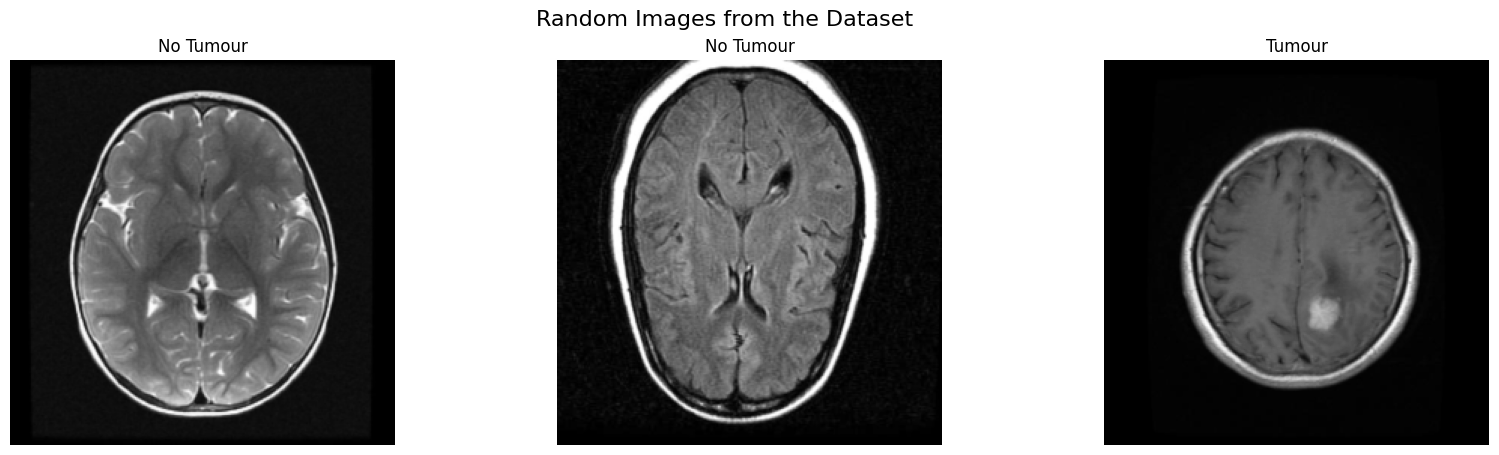

Image shape:  torch.Size([256, 256])


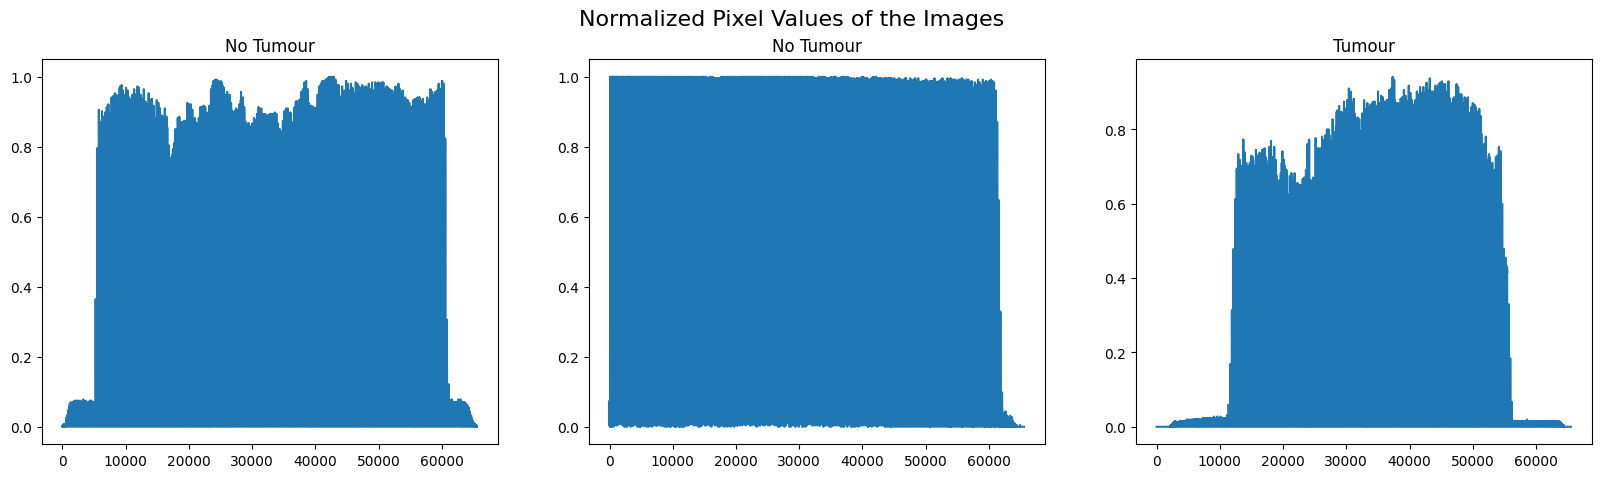

In [64]:
# display 5 random images from the dataset
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Random Images from the Dataset\n', fontsize=16)
choices = random.sample(range(len(training_set)), 3)
for i in range(3):
    img, label = training_set[choices[i]]
    ax[i].imshow(img.squeeze(), cmap='gray')
    ax[i].set_title("Tumour" if label == 1 else "No Tumour")
    ax[i].axis('off')

plt.show()

print("Image shape: ", img.squeeze().shape)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Normalized Pixel Values of the Images\n', fontsize=16)
for i in range(3):
    img, label = training_set[choices[i]]
    
    x = np.arange(0, img.shape[1] * img.shape[2])
    y = img.numpy().flatten()
    ax[i].plot(x, y)
    ax[i].set_title("Tumour" if label == 1 else "No Tumour")

plt.show()

In [87]:
# load .pt files for training, validation and testing

training_set = torch.load('../torch-dataset/training.pt')
training_set = training_set[:256]
val_set = torch.load('../torch-dataset/validation.pt')
test_set = torch.load('../torch-dataset/testing.pt')

In [88]:
batch_size = 8

In [89]:
d_train = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
d_val = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [27]:
kernel_size = 5

In [77]:
print("image size: ", training_set[0][0].shape)

image size:  torch.Size([1, 256, 256])


In [78]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=kernel_size, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=1),

    nn.Conv2d(32, 64, kernel_size=kernel_size, stride=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=1),

    nn.Conv2d(64, 128, kernel_size=kernel_size, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=kernel_size, stride=1),

    nn.Flatten(),
    nn.Linear(128 * 25 * 25, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

# check the output size
print("-------------------Checking input-output compatibility-------------------")
print("Input shape: ", training_set[0][0].shape)
x = training_set[0][0].unsqueeze(0)
out = model(x)
print("Output shape: ", out.shape)
print("Output: ", out.flatten().item())

-------------------Checking input-output compatibility-------------------
Input shape:  torch.Size([1, 256, 256])
Output shape:  torch.Size([1, 1])
Output:  0.5069765448570251


In [91]:
# define the loss function and the optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [92]:
epochs = 10

# training loop
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for image, label in d_train:
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output.flatten(), label.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    with torch.no_grad():
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        for image, label in d_val:
            output = model(image)
            loss = criterion(output.flatten(), label.float())
            val_loss += loss.item()
            output = (output > 0.5).flatten().int()
            correct += (output == label).sum().item()
            total += output.size(0)
        
        print(f"Epoch {epoch+1}, training loss: {running_loss / len(d_train)}, val_loss: {val_loss / len(d_val)}, val_acc: {correct / total}")



Epoch 1, training loss: 0.2081801762105897, val_loss: 0.3301277564544427, val_acc: 0.8775510204081632
Epoch 2, training loss: 0.2335185679166898, val_loss: 0.35133430244106995, val_acc: 0.8571428571428571


KeyboardInterrupt: 